# Méthode semi-Lagrangienne généralisée

Cette méthode ne fait pas d'interpolation à chaque itération en temps, mais revient à la condition initiale sur la 
grille grâce aux caractéristiques.

Une amélioration possible est de procéder à une interpolation tous les $T$ itérations afin de ne pas avoir de soucis
dans la quadrature lorsque les caractéristiques tendent à converger vers une zone restreinte du domaine d'étude.

In [1]:
using LinearAlgebra, QuadGK, Roots, FFTW, FastGaussQuadrature
using VlasovSolvers
import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PIC_step!, ParticleMover
using Plots
using ProgressMeter

using LaTeXStrings

In [2]:
struct RectangleRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function RectangleRule(len, start, stop)
        points = LinRange(start, stop, len+1)[1:end-1]
        s = step(points) 
        weights = [s for _ = 1:len]
        new(len, start, stop, vec(points), weights, s)
    end
end

In [3]:
struct TrapezoidalRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function TrapezoidalRule(len, start, stop)
        points = LinRange(start, stop, len)[1:end]
        s = step(points) 
        weights = [s for _ = 1:len]
        weights[1] /= 2
        weights[end] /= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [4]:
struct SimpsonRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function SimpsonRule(len, start, stop)
        # make sure the number of points is uneven
        if len % 2 == 0
            len += 1
        end
        points = LinRange(start, stop, len)
        s = step(points) 
        weights = s/3 .* ones(len)
        weights[2:2:end-1] .*= 4
        weights[3:2:end-2] .*= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [5]:
struct GaussLegendreRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLegendreRule(len, start, stop)
        points, weights = gausslegendre(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [6]:
struct GaussRadauRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussRadauRule(len, start, stop)
        points, weights = gaussradau(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [7]:
struct GaussLobattoRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLobattoRule(len, start, stop)
        points, weights = gausslobatto(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [8]:
struct KronrodRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function KronrodRule(len, start, stop)
        pts, w, _ = kronrod(len)
        weights = []
        points = []
        for i = 1:len
            push!(points, pts[i])
            push!(weights, w[i])
            push!(points, -pts[i])
            push!(weights, w[i])
        end
        push!(points, pts[end])
        push!(weights, w[end])
        
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        len = 2*len + 1
        new(len, start, stop, points, weights)
end
    end

In [9]:
struct rkn_order4
    a :: Array{Float64, 2}
    b̄ :: Vector{Float64}
    c :: Vector{Float64}
    b :: Vector{Float64}
    dt :: Float64
    fg ::       Array{Float64, 2}
    G ::        Array{Float64, 1}
    tmpcos ::   Array{Float64, 1}
    tmpsin ::   Array{Float64, 1}
    C :: Vector{Float64}
    S :: Vector{Float64}

    function rkn_order4(X, dt)
        # a, b̄, c, b correspond to the Butcher tableau
        a = [0.0        0.0       0.0; 
            (2-√3)/12   0.0           0.0; 
            0.0         √(3)/6      0.0]
        b̄ = [(5 - 3*√3)/24,     (3+√3)/12,  (1+√3)/24]
        c = [(3+√3)/6,          (3-√3)/6,   (3+√3)/6]
        b = [(3-2*√3)/12,       1/2,        (3+2*√3)/12]

        new(a .* dt^2, b̄ .* dt^2, c .* dt, b .* dt, dt,
            zeros(Float64, length(X), 3), 
            similar(X), 
            similar(X),
            similar(X), [0.0], [0.0])
    end
end

In [10]:
#= ==================== symplectic_RKN_order4!
Advect (X, V) on a time step dt using symplectic Runge-Kutta-Nystrom method of order4 [FQ10, sect.7.3, p.327, scheme1].

The equation satisfied by X is d^2(X(t)) / dt^2 = C(t)\cos(X(t)) - S(t)sin(X(t)).

RKN method considers Ẋ = V as a variable, and updates both X and V.

Using a change of variable and the jacobian of the flow being equal to 1, it is enough to know the function f on some
initial fixed grid, independant of time, to compute C(t) and S(t).

Args:
- X: matrix of positions at time t_n
- V: matrix of velocities at time t_n
- F: values of initial condition at time t_0
- rkn: rkn_order_4 struct, storing butcher tableau and pre-allocated arrays.
- kx: 2π/L

Updates X, V in place, and returns coefficients C, S at current time. 
==================== =#
function symplectic_RKN_order4!(X, V, F, rkn, kx)  
    @views begin
        for s=1:3
            rkn.G .= X .+ V .* rkn.c[s] .+ rkn.a[s, 1] .* rkn.fg[:, 1] .+ rkn.a[s, 2] .* rkn.fg[:, 2] .+ rkn.a[s, 3] .* rkn.fg[:, 3]
            
            rkn.G .*= kx
     
            rkn.tmpcos .= cos.(rkn.G)
            rkn.tmpsin .= sin.(rkn.G)
            sum!(rkn.C, rkn.tmpcos .* F)
            sum!(rkn.S, rkn.tmpsin .* F)
            rkn.C ./= π
            rkn.S ./= π
            rkn.fg[:, s] .= (rkn.C[1] .* rkn.tmpsin .- rkn.S[1] .* rkn.tmpcos)
        end
    
        X .+= rkn.dt .* V .+ rkn.b̄[1] .* rkn.fg[:, 1] .+ rkn.b̄[2]  .* rkn.fg[:, 2] .+ rkn.b̄[3]  .* rkn.fg[:, 3]
        V .+= rkn.b[1] .* rkn.fg[:, 1] .+ rkn.b[2] .* rkn.fg[:, 2] .+ rkn.b[3] .* rkn.fg[:, 3]
        rkn.tmpcos .= cos.(X .* kx)
        rkn.tmpsin .= sin.(X .* kx)
        sum!(rkn.C, rkn.tmpcos .* F)
        sum!(rkn.S, rkn.tmpsin .* F)
    end
    return @views rkn.C[1], rkn.S[1]
end

symplectic_RKN_order4! (generic function with 1 method)

In [11]:
function strang_splitting!(X, V, F, kx, dt)  
    X .+= V .* dt/2
    C = sum(cos.(X .* kx) .* F)
    S = sum(sin.(X .* kx) .* F)
    dphidx = (-C.*sin.(X .* kx) + S.*cos.(X .* kx)) ./ π
    V .-= dt .* dphidx
    X .+= V .* dt/2
    return C, S
end

strang_splitting! (generic function with 1 method)

## SL Généralisée

In [23]:
function generalized_SL(nsteps::Int64, dt::Float64, quadrulex, quadrulev, kx, f0::Function; plotting=false::Bool)

    C = 0.0
    S = 0.0

    newX = vec(repeat(quadrulex.points, 1, quadrulev.len))   # newX[i, j] is position at current time when starting from x0_i, v0_j
    newV = vec(repeat(quadrulev.points', quadrulex.len, 1))  # newV[i, j] is velocity at current time when starting from x0_i, v0_j
    
    E²_elec  = Array{Float64}(undef, nsteps)
    E²_tot   = Array{Float64}(undef, nsteps)

    rkn = rkn_order4(newX, dt)

    if plotting
        widthx = -(-)(extrema(quadrulex.points)...)
        widthv = -(-)(extrema(quadrulev.points)...)
        scale = 25
    end
    
    progression = ProgressMeter.Progress(nstep,desc="Loop in time: ", showspeed=true)
        
    f0vals = vec(f0.(quadrulex.points, quadrulev.points') .* quadrulex.weights .* quadrulev.weights')

    animation = @animate for istep=1:nsteps
        C, S = symplectic_RKN_order4!(newX, newV, f0vals, rkn, kx)
        # C, S = strang_splitting!(newX, newV, f0vals, kx, dt)
        
        E²_elec[istep] = (C^2 + S^2) * quadrulex.stop / (2*π^2)
        E²_tot[istep] = (E²_elec[istep] + sum(newV.^2 .* f0vals)) / 2 
        
        newX[findall(x -> x > quadrulex.stop,  newX)] .-= quadrulex.stop - quadrulex.start
        newX[findall(x -> x < quadrulex.start, newX)] .+= quadrulex.stop - quadrulex.start
 
        if plotting
            # histogram2d(vec(newX), vec(newV), weights=vec(f0vals), bins=(nx, nv).*3, normalize=true, xlabel="position", ylabel="velocity", fillcolor=:roma, aspect_ratio=:equal)
            markerscale = 20
            plot(newX, newV, f0vals, seriestype=:scatter, markersize=sqrt(widthx * widthv * markerscale^2  / (nx*nv) / π), camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=vec(f0vals), c=:rainbow,aspect_ratio=:equal, size=(widthx, widthv).* 30)
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        ProgressMeter.next!(progression)
     end when plotting

     return sqrt.(E²_elec), sqrt.(E²_tot), animation, newX, newV, f0vals
end

generalized_SL (generic function with 1 method)

## SL classique

In [13]:
"""
    hmf_poisson!(fᵗ    :: Array{Complex{Float64},2},
                 mesh1 :: OneDGrid,
                 mesh2 :: OneDGrid,
                 ex    :: Array{Float64})

    Compute the electric hamiltonian mean field from the
    transposed distribution function

"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2},
        mesh1::OneDGrid,
        mesh2::OneDGrid,
        ex::Array{Float64})

    n1 = mesh1.len
    rho = mesh2.step .* vec(sum(fᵗ, dims=1)) # ≈ ∫ f(t,x_i,v)dv, i=1, ..., n1
    rho .-= sum(rho) * mesh1.step / mesh1.stop
    kernel = zeros(Float64, n1)
    k = -(mesh1.stop - mesh1.start) / (2π)
    kernel[2]   =  k    # fourier mode  1
    kernel[end] = -k    # fourier mode -1
    ex .= real(ifft(fft(rho) .* 1im .* kernel))
end


function solve_SL!(nsteps, dt, f, mesh1, mesh2; plotting=false::Bool)
    n1, n2 = size(f)
    fᵗ = zeros(Complex{Float64}, (n2,n1))
    transpose!(fᵗ, f)

    energy = Array{Float64}(undef, nsteps)

    ex = zeros(Float64, n1)
    hmf_poisson!(fᵗ, mesh1, mesh2, ex)
    advection!(fᵗ, mesh2, ex, 0.5dt)

    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    
    animation = @animate for istep = 1:nsteps
        energy[istep] = sqrt(sum(ex.^2) * mesh1.step)
        # etot[istep] = sqrt(energy[istep]^2 + sum()*mesh1.step*mesh2.step)
    
        if plotting
            plot(mesh1.points, mesh2.points, real(f)', size=(500, 500), st=:surface, camera=(0, 90))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        advection!(f, mesh1, mesh2.points, dt)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, mesh1, mesh2, ex)
        advection!(fᵗ, mesh2, ex, dt)
        transpose!(f, fᵗ) 
        ProgressMeter.next!(progression)
    end when plotting
    if plotting
        return energy, ex, animation
    else
        return energy, ex, nothing
    end
end

solve_SL! (generic function with 1 method)

# INPUTS

## Landau damping

In [ ]:
kx = 0.5
L = 2π / kx
ϵ = 0.001
μ = 0.0
β = 1.0
f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * (v-μ)^2 / 2) / √(2π/β)
castest = "Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

## Two-Stream Instability

### Première version

In [ ]:
kx = 0.2
L = 2π / kx
ϵ = 0.001
β₁ = 1
β₂ = 1
v0 = 2.4
μ₁ =  v0
μ₂ = -v0
f(x,v) = (1 + ϵ * cos(kx * x)) * (exp(-β₁*(v-μ₁)^2 / 2) + exp(-β₁*(v-μ₂)^2 / 2)) / (√(2π)) * 0.5
castest = "TSI\n(kx, β₁, β₂, μ₁, μ₂) = $((kx, β₁, β₂, μ₁, μ₂))"

### Seconde version

In [ ]:
kx = 0.2
L = 2π / kx
ϵ = 0.001
β = 1
μ =  0
f(x,v) = (1 + ϵ * cos(kx * x)) * v^2 * exp(-β*(v-μ)^2 / 2) / (√(2π))
castest = "TSI\n(kx, β, μ) = $((kx, β, μ))"

## Bump-on-Tail

In [14]:
kx = 0.3
L = 2π / kx
ϵ = 0.04
β₁ = 1
β₂ = 1 / (0.5^2)
μ₁ = 0
μ₂ = 4.5
nb = 0.2
np = 0.9
f(x,v) = (1 + ϵ * cos(kx*x)) * (np*exp(-β₁*(v-μ₁)^2 /2) + nb*exp(-β₂*(v-μ₂)^2 / 2)) / √(2π)
castest = "Bump on tail\n(kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np) = $((kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np))"

"Bump on tail\n(kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np) = (0.3, 0.04, 1, 4.0, 0, 4.5, 0.2, 0.9)"

## Strong Landau Damping

In [ ]:
kx = 0.5
L = 2π / kx
ϵ = 0.5
β = 1.0
μ = 0.0
f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * v^2 / 2) / √(2π/β)
castest = "Strong Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

# Inputs indépendants du cas test

In [15]:
dev = CPU()

nstep = 100
dt = 1.0

1.0

In [38]:
nx = 16
nv = 32

meshx = OneDGrid(dev, nx, 0, L);
meshv = OneDGrid(dev, nv, -10, 10);

quadX = TrapezoidalRule
quadV = TrapezoidalRule

quadrulex = quadX(nx, 0, L);
quadrulev = quadV(nv, -10, 10);

# Simulations

In [39]:
gsl  = zeros(Complex{Float64}, (nx,nv));
@. gsl = f.(meshx.points, meshv.points');
@time E_elecsl, _, animationsl = solve_SL!(nstep, dt, gsl, meshx, meshv, plotting=false);

  0.072046 seconds (369.74 k allocations: 14.663 MiB)


In [40]:
p = false
@time E_elec, E_tot, animation, X, V, F = generalized_SL(nstep, dt, quadrulex, quadrulev, kx, f, plotting=p);

  0.008047 seconds (18.12 k allocations: 5.018 MiB)


In [41]:
# meshx_2 = OneDGrid(dev, 64, 0, L)
# meshv_2 = OneDGrid(dev, 65, -10, 10)

meshx_2 = meshx
meshv_2 = meshv

gsl_2  = zeros(Complex{Float64}, (meshx_2.len, meshv_2.len))
@. gsl_2 = f.(meshx_2.points, meshv_2.points');
@time E_elecsl_2, _, animationsl = solve_SL!(2000, 0.05, gsl_2, meshx_2, meshv_2, plotting=false);

Loop in time: 100%|███████████████████████| Time: 0:00:01 ( 0.75 ms/it)


  1.500347 seconds (7.37 M allocations: 292.193 MiB, 4.64% gc time)


In [42]:
# quadrulex_2 = quadX(64, 0, L);
# quadrulev_2 = quadV(65, -10, 10);

quadrulex_2 = quadrulex
quadrulev_2 = quadrulev

@time E_elec_2, E_tot_2, animation_2, X_2, V_2, F_2 = generalized_SL(2000, 0.05, quadrulex_2, quadrulev_2, kx, f, plotting=p);
# nstep=1000: 3.852896 seconds (558.21 k allocations: 4.159 GiB, 9.63% gc time)
# nstep=5000: 20.110145 seconds (1.76 M allocations: 20.773 GiB, 8.93% gc time)

  0.136170 seconds (89.91 k allocations: 91.690 MiB, 9.59% gc time)


In [43]:
if p
    gif(animation, "generalized_semilag.gif")
end

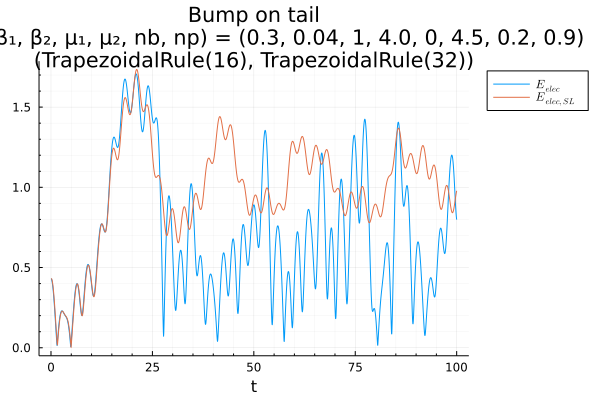

In [44]:
t = (1:nstep).*dt
t_2 = (1:2000).*0.05

# energies
plot(t_2, E_elec_2, label=L"E_{elec}", legend=:outertopright, minorgrid=true)
plot!(t_2, E_elecsl_2, label=L"E_{elec, SL}", legend=:outertopright, minorgrid=true)
# plot!(t, E_tot, label=L"E_{tot}", scaley=:log10)

# log(Energies)
# plot(t, log.(E_elec),       label=L"\log(E_{elec}),\quad dt="*"$(dt)", legend=:bottomright, minorgrid=true)
# plot!(t_2, log.(E_elec_2),       label=L"\log(E_{elec}), \quad dt=0.05")
# plot!(t, log.(E_elecsl),    label=L"\log(E_{elec, SL}),\quad dt="*"$(dt)", ls=:dash, lw=1)
# plot!(t_2, log.(E_elecsl_2),    label=L"\log(E_{elec, SL}), \quad dt=0.05", ls=:dash, lw=1)
# plot!(t, log.(E_tot),       label=L"\log(E_{tot}),\quad dt="*"$(dt)")
# plot!(t_2, log.(E_tot_2),       label=L"\log(E_{tot}), \quad dt=0.05")


# ============== #

# Landau damping (kx=0.5):
# plot!(x->-0.1533x - 5.6, label="Damping attendu (-0.1533)")
# E_th = abs.(4ϵ * 0.3677 .* exp.(−0.1533 .* t_2) .* cos.(1.4156.*t_2 .−0.5326245) .* sqrt(L/2))
# plot!(t_2, log.(E_th),label="Energie theorique", ls=:dash)
# Landau damping (kx=0.4):
# plot!(x->-0.0661x - 5.3, label="Damping attendu (-0.0661)")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
# E_th = abs.(4*ϵ*0.424666*exp.(-0.0661 .* t) .* cos.(1.2850 .* t .- 0.3357725) * sqrt(L/2)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
# plot!(t, log.(E_th) .- log(2),label="Energie theorique", ls=:dash)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, -0.001t .- 4.2, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 6.4, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 6.1, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .+ 1, label=L"y=-0.285473t + 1")
# plot!(t, 0.086671t .- 3.5, label=L"y=0.086671t - 3.5")

title!(castest * "\n($(quadX)($(nx)), $(quadV)($(nv)))")
xlabel!("t")

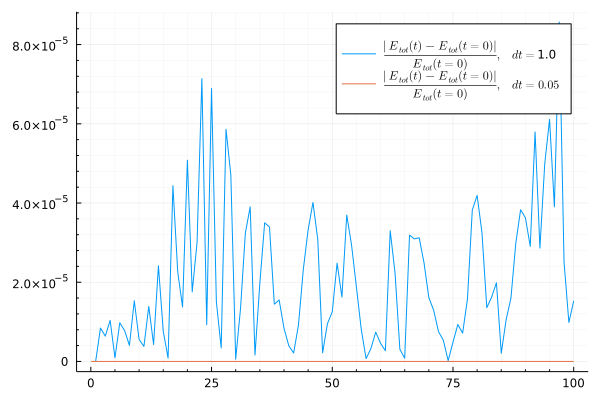

In [45]:
plot(t, abs.((E_tot .- E_tot[1])) ./ E_tot[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)},\quad dt="*"$(dt)", minorgrid=true)
plot!(t_2, abs.((E_tot_2 .- E_tot_2[1])) ./ E_tot_2[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}, \quad dt=0.05")

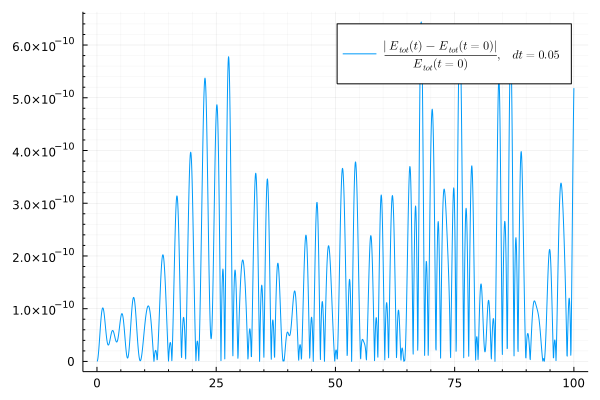

In [46]:
plot(t_2, abs.((E_tot_2 .- E_tot_2[1])) ./ E_tot_2[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}, \quad dt=0.05", minorgrid=true)
# plot!(t, abs.((E_tot .- E_tot[1])) ./ E_tot[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}, \quad dt=1.0", minorgrid=true)

# Comparaison des énergies electriques entre SL et méthode des caractérististiques

In [ ]:
function comparison_eletricalEnergy(nsteps::Int64, dt::Float64, L, vmax, kx, f0::Function)

    nx = 512
    nv = 512

    

    E²_elec_charac = Array{Float64}(undef, nsteps)

    quadX = GaussRadauRule
    quadV = TrapezoidalRule
    
    quadrulex = quadX(nx, 0, L);
    quadrulev = quadV(nv, -vmax, vmax);

    newX = vec(repeat(quadrulex.points, 1, quadrulev.len))
    newV = vec(repeat(quadrulev.points', quadrulex.len, 1))
    
    rkn = rkn_order4(newX, dt)
    f0vals = vec(f0.(quadrulex.points, quadrulev.points') .* quadrulex.weights .* quadrulev.weights')

    
    
    E²_elec_sl = Array{Float64}(undef, nsteps)
    meshx = OneDGrid(dev, nx, 0, L)
    meshv = OneDGrid(dev, nv, -vmax, vmax)
    g = zeros(Complex{Float64}, (nx, nv))
    @. g = f0.(meshx.points, meshv.points')
    gᵗ = zeros(Complex{Float64}, (nv,nx))
    transpose!(gᵗ, g)

    ex = zeros(Float64, nx)
    hmf_poisson!(gᵗ, meshx, meshv, ex)
    advection!(gᵗ, meshv, ex, 0.5dt)

    
    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
        
    norm²EelecslminusEeleccharac = []


    for istep=1:nsteps
        # Characteristics method:
        C, S = symplectic_RKN_order4!(newX, newV, f0vals, rkn, kx)    
        E²_elec_charac[istep] = (C^2 + S^2) * quadrulex.stop / (2*π^2)
        newX[findall(x -> x > quadrulex.stop,  newX)] .-= quadrulex.stop - quadrulex.start
        newX[findall(x -> x < quadrulex.start, newX)] .+= quadrulex.stop - quadrulex.start
 
        # SL
        E²_elec_sl[istep] = sum(ex.^2) * meshx.step
        advection!(g, meshx, meshv.points, dt)
        transpose!(gᵗ, g)
        hmf_poisson!(gᵗ, meshx, meshv, ex)
        advection!(gᵗ, meshv, ex, dt)
        transpose!(g, gᵗ) 

        ## norme L2 de la difference des energies electriques
        push!(norm²EelecslminusEeleccharac, sum((-ex .- (-C .* sin.(meshx.points .* 2π/L) .+ S .* cos.(meshx.points .* 2π/L))/π).^2) * meshx.step)
        
        ProgressMeter.next!(progression)
     end

     return E²_elec_charac, E²_elec_sl, sqrt.(norm²EelecslminusEeleccharac), (1:nsteps).*dt, ex
end

In [ ]:
@time E²_elec_charac, E²_elec_sl, L2Eelec, arrt, ex = comparison_eletricalEnergy(2000, 0.05, L, 10., kx, f);

In [ ]:
plot(arrt, L2Eelec, label=L"||E_{elec, charac} - E_{elec, SL}||_2", minorgrid=true)

In [ ]:
plot(arrt, E²_elec_charac, label=L"\Phi_{charac}", minorgrid=true)
plot!(arrt, E²_elec_sl, label=L"\Phi_{SL}")

In [ ]:
plot(arrt, (E²_elec_charac .- E²_elec_sl).^2 * dt)